## Importing data

In [122]:
# Basic stuff
import numpy as np
import seaborn as sns
import pandas as pd
from pathlib import Path

# General stuff
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold, ShuffleSplit, StratifiedKFold, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, make_scorer
# Models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
# Importing pre-processed (non-zero filtered data)
HERE = Path(_dh[-1])
DATA = HERE.parent/'data'/'fda_approved'/'fda_rdkit_pre_processed_descriptors.csv'

drugs_and_descriptors = pd.read_csv(DATA)
print(drugs_and_descriptors.columns)

Index(['name', 'chembl_id', 'clean_smiles', 'first_approval_year',
       'indication_class', 'molecule_type', 'withdrawn_flag',
       'therapeutic_flag', 'polymer_flag', 'inorganic_flag',
       ...
       'fr_quatN', 'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone',
       'fr_term_acetylene', 'fr_tetrazole', 'fr_thiazole', 'fr_thiophene',
       'fr_unbrch_alkane', 'fr_urea'],
      dtype='object', length=215)


### Separating X and y matrices

We must separate descriptors from non-descriptors, i.e. separate the X matrix from the expected Y values.

In [3]:
not_descriptors = [
    'name','chembl_id','clean_smiles','first_approval_year',
    'indication_class','molecule_type','withdrawn_flag','therapeutic_flag',
    'polymer_flag','inorganic_flag','natural_product_flag','parenteral','topical','oral'
]
X = drugs_and_descriptors.drop(columns=not_descriptors) # descriptor matrix
y = drugs_and_descriptors['oral'] # response variable

## Removing Collinear Variables

Multicolinearity is a no good. Time to remove some variables that are highly correlated with each other, to see if that somewhat improves the classifers.

#### Before removing high-correlated variables

<Axes: >

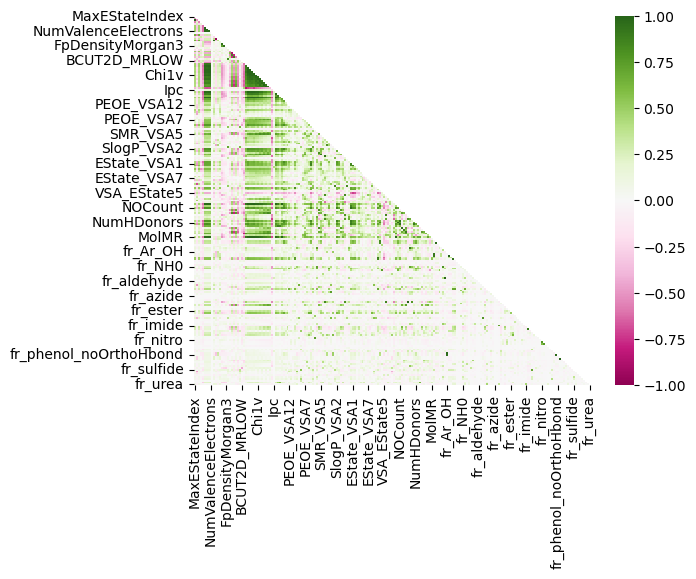

In [106]:
mask = np.triu(np.ones_like(X.corr()))
sns.heatmap(X.corr(), cmap="PiYG",annot=False, mask=mask, vmin=-1, vmax=1)

I built a helper function to melt/flat the correlation matrix of the descriptors (independent variables) and returns only the upper triangle, also removing the values where it compares it to itself `(r(desc_x) == r(desc_x))`.

In [64]:
def flat_descriptor_matrix(X):
    """
    Flattens out a given descriptor matrix and returns 
    the pairwise comparison of the upper traingle
    """
    correlation_matrix =  X.corr()
    # only upper triangle
    correlation_matrix = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape)).astype(bool))
    # flat it out
    flat_corr_matrix = correlation_matrix.stack().reset_index()
    flat_corr_matrix.columns = ['desc1', 'desc2', 'value']

    # Dropping the values where the pairwise comparison is with itself
    flat_corr_matrix = flat_corr_matrix[~(flat_corr_matrix['desc1'] == flat_corr_matrix['desc2'])].reset_index()


    return flat_corr_matrix

Let's investigate how many pairwise correlation of descriptors have high values:

In [88]:
flat_corr_matrix = flat_descriptor_matrix(X)

# How many variables correlation are greater than 0.70, 0.80, 0.85, 0.90 and 0.95?
thresholds = [0.70,0.80,0.85,0.90,0.95]

flat_corr_matrix[flat_corr_matrix.value >= 0.70].shape[0]

for threshold in thresholds:
   print(f"{flat_corr_matrix[abs(flat_corr_matrix.value) >= threshold].shape[0]} values of pairwise correlation of descriptors above the absolute threshold {threshold}")

506 values of pairwise correlation of descriptors above the absolute threshold 0.7
283 values of pairwise correlation of descriptors above the absolute threshold 0.8
227 values of pairwise correlation of descriptors above the absolute threshold 0.85
167 values of pairwise correlation of descriptors above the absolute threshold 0.9
111 values of pairwise correlation of descriptors above the absolute threshold 0.95


### After removing high-correlated variables

In [93]:
def remove_collinear_features(X, threshold):
    corr_matrix = X.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            if val >= threshold:
                drop_cols.append(col.values[0])
    
    drops = set(drop_cols)
    X = X.drop(columns=drops)
    print(f"Removed Columns {drops}")

    return X

In [94]:
X_no_collinear = remove_collinear_features(X, 0.80)

Removed Columns {'FpDensityMorgan3', 'HeavyAtomCount', 'Chi0', 'Chi2n', 'SlogP_VSA5', 'EState_VSA1', 'NumHeteroatoms', 'NumValenceElectrons', 'Kappa2', 'fr_phos_ester', 'fr_benzene', 'fr_COO', 'BCUT2D_LOGPHI', 'HallKierAlpha', 'NumAromaticCarbocycles', 'MaxAbsPartialCharge', 'Kappa3', 'SMR_VSA5', 'NumHAcceptors', 'NumSaturatedCarbocycles', 'Chi2v', 'fr_C_O', 'fr_Nhpyrrole', 'NumSaturatedRings', 'fr_Al_OH', 'SlogP_VSA2', 'EState_VSA10', 'Kappa1', 'NumHDonors', 'RingCount', 'Chi0v', 'VSA_EState10', 'MolMR', 'SlogP_VSA6', 'LabuteASA', 'Chi4v', 'HeavyAtomMolWt', 'NumRotatableBonds', 'NOCount', 'VSA_EState2', 'NumSaturatedHeterocycles', 'fr_phenol', 'Chi0n', 'BCUT2D_CHGLO', 'NHOHCount', 'MinAbsPartialCharge', 'fr_ketone_Topliss', 'VSA_EState6', 'Chi4n', 'fr_phenol_noOrthoHbond', 'Chi1n', 'Chi3n', 'fr_Al_OH_noTert', 'MaxAbsEStateIndex', 'ExactMolWt', 'fr_COO2', 'SlogP_VSA4', 'Chi1', 'FpDensityMorgan2', 'fr_C_O_noCOO', 'Chi3v', 'BCUT2D_MRHI', 'BCUT2D_LOGPLOW', 'NumAromaticRings', 'Chi1v', 'TP

In [108]:
print(f"Before removing the {X.shape[1]}, after removing collinear features:{X_no_collinear.shape[1]}")

Before removing the 201, after removing collinear features:132


<Axes: >

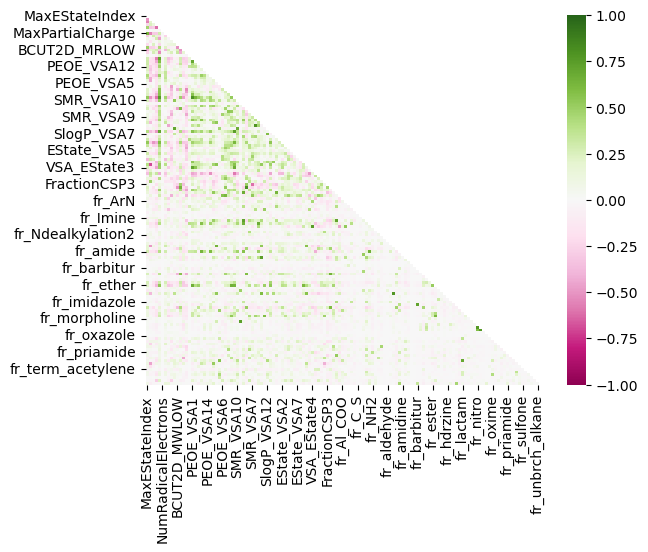

In [105]:
mask = np.triu(np.ones_like(X_no_collinear.corr()))
sns.heatmap(X_no_collinear.corr(), cmap="PiYG",annot=False, mask=mask, vmax=1.0, vmin=-1.0)

## Cross-validation

Comparing the models using Logistic Regression, KNN, SVM and Random Forest:

In [99]:
models = [
    LogisticRegression(max_iter=500), 
    SVC(kernel='poly'),
    SVC(kernel='rbf'),
    SVC(kernel='linear'),
    KNeighborsClassifier(n_neighbors=5), 
    RandomForestClassifier(n_estimators=100), 
    SGDClassifier(loss="hinge", penalty="l2", max_iter=500), 
    GradientBoostingClassifier()]

In [102]:
# Pre processing:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_no_collinear)

In [103]:
results = []
for model in models:
    scoring = ['roc_auc', 'accuracy', 'balanced_accuracy']
    scores = cross_validate(model, X_scaled, y, cv=10, scoring=scoring, return_train_score=False)
    for score, array in scores.items():
        results.append({"model": str(model), "score": score, "mean": np.mean(array)})

In [104]:
results_df = pd.DataFrame(results)
results_df

,model,score,mean
0,LogisticRegression(max_iter=500),fit_time,0.133314
1,LogisticRegression(max_iter=500),score_time,0.007798
2,LogisticRegression(max_iter=500),test_roc_auc,0.656201
3,LogisticRegression(max_iter=500),test_accuracy,0.640699
4,LogisticRegression(max_iter=500),test_balanced_accuracy,0.601718
5,SVC(kernel='poly'),fit_time,0.183715
6,SVC(kernel='poly'),score_time,0.030475
7,SVC(kernel='poly'),test_roc_auc,0.686937
8,SVC(kernel='poly'),test_accuracy,0.664467
9,SVC(kernel='poly'),test_balanced_accuracy,0.578935


## Hyperparameter tuning

In [125]:
svm_model = SVC()
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

parameters = {
    'kernel': ['poly', 'rbf', 'sigmoid', 'linear'],
    'C': [0.1, 1, 5, 10, 20]
}
classifier = GridSearchCV(svm_model, param_grid=parameters, cv=10, scoring=scoring, refit='AUC')

In [126]:
classifier.fit(X_scaled, y)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.1, 1, 5, 10, 20],
                         'kernel': ['poly', 'rbf', 'sigmoid', 'linear']},
             refit='AUC',
             scoring={'AUC': 'roc_auc',
                      'Accuracy': make_scorer(accuracy_score)})

In [127]:
classifier.best_params_

{'C': 1, 'kernel': 'rbf'}

In [128]:
classifier.best_score_

0.7037516249087229